**Initialization**

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import pandas as pd
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import math
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
!ls "/content/drive/My Drive/COMP551/"
from IPython.core.debugger import set_trace

Mounted at /content/drive/
breast_cancer_wisconsin.csv  hepatitis.csv


**KNN Data Structure**

In [2]:
#K-Nearest Neighbor
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
minkowski = lambda x1, x2: (np.sum((np.abs(x1 - x2))*7, axis=-1))**(1/7)


class KNN: 

  def __init__(self, K=1, dist_fn = euclidean):
    self.dist_fn = dist_fn
    self.K = K
    return 

  def fit(self,x,y):
    #lazy learner
    self.x = x
    self.y = y
    self.C = int(np.max(y))+1    #len(set(y)) #nb of classifications maybe np.max(y)+1
    return self
    
  def predict(self, x_test):
    num_test = x_test.shape[0] #dimensions of testing data
    distances = self.dist_fn(self.x[None,:,:],x_test[:,None,:]) #distance between training and test
    knns = np.zeros((num_test,self.K),dtype=int)
    y_prob  = np.zeros((num_test,self.C)) #probability distribution over C classes
    for i in range(num_test):
      knns[i,:] = np.argsort(distances[i])[:self.K]
      y_prob[i,:] = np.bincount(self.y[knns[i,:]],minlength=self.C) 
    y_prob /= self.K #scaling from 0 to 1
    return y_prob, knns
  
  def evaluate_acc(self, y_true, y_target):
    accuracy = np.sum(y_true == y_target)/y_true.shape[0]
    return accuracy

#removing outliers
def remove_outliers(arr, k):
    mu, sigma = np.mean(arr, axis=0), np.std(arr, axis=0, ddof=1)
    return arr[np.all(np.abs((arr - mu) / sigma) < k, axis=1)]

**Decision Tree Data Structure**

In [3]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

#different cost functions
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

#implementing the decision tree
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_gini_index, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def _fit_tree(self, node):
        pass

    def predict(self, data_test):
        pass

#fit functions
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

#prediction of data
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

#Declaring functions to Decision Tree Class
DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree
DecisionTree.predict = predict

**Breast Cancer Data Set Preparation**

In [4]:
#Declaring data as a pandas dataframe and cleaning out rows with missing values
bc_data=pd.read_csv("/content/drive/My Drive/COMP551/breast_cancer_wisconsin.csv")

bc_df=bc_data[~bc_data.eq('?').any(1)]
del bc_df["id"]
bc_df=bc_df.drop_duplicates()


#Converting from a dataframe to an array
bc_all = bc_df[["Class","Clump_Thickness","Uniformity_of_Cell_Size","Uniformity_of_Cell_Shape","Marginal_Adhesion","Single_Epithelial_Cell_Size","Bare_Nuclei","Bland_Chromatin","Normal_Nucleoli","Mitoses"]].to_numpy()
bc_all = bc_all.astype(np.int)
bc_all = remove_outliers(bc_all,3)
print(len(bc_all))

bc_x = bc_all[:,1:10]
bc_y = bc_all[:,0]

bc_y[bc_y==2]=0
bc_y[bc_y==4]=1

#Splitting the data into test and train datasets
(N,D), C = bc_x.shape, np.max(bc_y)+1
inds = np.random.permutation(N)     
bc_x = bc_x.astype(np.int)
bc_y = bc_y.astype(np.int)
x_train, y_train = bc_x[inds[:305]], bc_y[inds[:305]]
x_test, y_test = bc_x[inds[305:]], bc_y[inds[305:]]
x_corr = bc_x[:, [1, 2]]
x_train_corr = x_train[:, [1, 2]]

#for bc dataframe assume class value of 2 is positive and 4 is negative
#split dataframe into class value 2 and 4
pos_bc=bc_df[bc_df["Class"]==2]
neg_bc=bc_df[bc_df["Class"]==4]


#Summary statistics for breast cancer dataset
bc_df_num = bc_df.apply(pd.to_numeric, errors='coerce')
bc_stat = bc_df[["Clump_Thickness","Uniformity_of_Cell_Size","Uniformity_of_Cell_Shape","Marginal_Adhesion","Single_Epithelial_Cell_Size","Bare_Nuclei","Bland_Chromatin","Normal_Nucleoli","Mitoses"]]
bc_stat = bc_stat.apply(pd.to_numeric, errors='coerce')
bc_desc = bc_stat.describe()
bc_desc = bc_desc.drop(['count', '25%','50%','75%'])


bc_desc.loc[len(bc_desc.index)] = [bc_df_num["Clump_Thickness"].corr(bc_df_num["Class"]),bc_df_num["Uniformity_of_Cell_Size"].corr(bc_df_num["Class"]),bc_df_num["Uniformity_of_Cell_Shape"].corr(bc_df_num["Class"]),bc_df_num["Marginal_Adhesion"].corr(bc_df_num["Class"]),bc_df_num["Single_Epithelial_Cell_Size"].corr(bc_df_num["Class"]),bc_df_num["Bare_Nuclei"].corr(bc_df_num["Class"]),bc_df_num["Bland_Chromatin"].corr(bc_df_num["Class"]),bc_df_num["Normal_Nucleoli"].corr(bc_df_num["Class"]),bc_df_num["Mitoses"].corr(bc_df_num["Class"])]  
bc_desc = bc_desc.rename(index={4:"correlation"})
display(bc_desc)

435


,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
mean,5.378619,4.222717,4.273942,3.746102,3.879733,4.806236,4.200445,3.828508,1.913140
std,2.869029,3.251280,3.141494,3.158413,2.456544,3.880509,2.651634,3.387146,2.068909
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
correlation,0.670230,0.758697,0.759500,0.630415,0.611432,0.760278,0.706738,0.645257,0.357184


**Hepatitis Data Set Preparation**

In [5]:
#Declaring data as a pandas dataframe and cleaning out rows with missing values

hep_data=pd.read_csv("/content/drive/My Drive/COMP551/hepatitis.csv")

#Cleaning data
hep_df=hep_data[~hep_data.eq('?').any(1)]
hep_df=hep_df.drop_duplicates() #no duplicates in this one


#Converting from a dataframe to an array
hep_all = hep_df[["Class","AGE","SEX","STEROID","ANTIVIRALS","FATIGUE","MALAISE","ANOREXIA","LIVER_BIG","LIVER_FIRM","SPLEEN_PALPABLE","SPIDERS","ASCITES","VARICES","BILIRUBIN","ALK_PHOSPHATE","SGOT","ALBUMIN","PROTIME","HISTOLOGY"]].to_numpy()
hep_all = hep_all.astype(np.float)
hep_all = remove_outliers(hep_all,3) #3 standard deviations

hep_x = hep_all[:,1:20]
hep_y = hep_all[:,0]

hep_y[hep_y==1]=0
hep_y[hep_y==2]=1

hep_x = hep_x.astype(np.float)
hep_y = hep_y.astype(np.int)

#Splitting the data into test and train datasets
(N,D), C = hep_x.shape, np.max(hep_y)+1
inds = np.random.permutation(N)

x_hep_train, y_hep_train = hep_x[inds[:52]], hep_y[inds[:52]]
x_hep_test, y_hep_test = hep_x[inds[52:]], hep_y[inds[52:]]

hep_x_corr = hep_x[:, [16, 17]]
x_hep_train_corr = x_hep_train[:, [16, 17]]

#split hep dataframe into two classes
pos_hep = hep_df[hep_df["Class"]==1]
neg_hep = hep_df[hep_df["Class"]==2]

#Summary statistics for hepatitis dataset
hep_df_num = hep_df.apply(pd.to_numeric, errors='coerce')
hep_stat = hep_df_num[["AGE","SEX","STEROID","ANTIVIRALS","FATIGUE","MALAISE","ANOREXIA","LIVER_BIG","LIVER_FIRM","SPLEEN_PALPABLE","SPIDERS","ASCITES","VARICES","BILIRUBIN","ALK_PHOSPHATE","SGOT","ALBUMIN","PROTIME","HISTOLOGY"]]

hep_desc = hep_stat.describe()
hep_desc = hep_desc.drop(['count', '25%','50%','75%'])

hep_desc.loc[len(hep_desc.index)] = [hep_df_num["AGE"].corr(hep_df_num["Class"]),hep_df_num["SEX"].corr(hep_df_num["Class"]),hep_df_num["STEROID"].corr(hep_df_num["Class"]),hep_df_num["ANTIVIRALS"].corr(hep_df_num["Class"]), hep_df_num["FATIGUE"].corr(hep_df_num["Class"]),hep_df_num["MALAISE"].corr(hep_df_num["Class"]),hep_df_num["ANOREXIA"].corr(hep_df_num["Class"]),hep_df_num["LIVER_BIG"].corr(hep_df_num["Class"]),hep_df_num["LIVER_FIRM"].corr(hep_df_num["Class"]),hep_df_num["SPLEEN_PALPABLE"].corr(hep_df_num["Class"]),hep_df_num["SPIDERS"].corr(hep_df_num["Class"]),hep_df_num["ASCITES"].corr(hep_df_num["Class"]),hep_df_num["VARICES"].corr(hep_df_num["Class"]),hep_df_num["BILIRUBIN"].corr(hep_df_num["Class"]),hep_df_num["ALK_PHOSPHATE"].corr(hep_df_num["Class"]),hep_df_num["SGOT"].corr(hep_df_num["Class"]),hep_df_num["ALBUMIN"].corr(hep_df_num["Class"]),hep_df_num["PROTIME"].corr(hep_df_num["Class"]),hep_df_num["HISTOLOGY"].corr(hep_df_num["Class"])]
hep_desc = hep_desc.rename(index={4:"correlation"})
display(hep_desc)


,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
mean,40.662500,1.137500,1.525000,1.737500,1.350000,1.612500,1.850000,1.837500,1.525000,1.812500,1.687500,1.850000,1.875000,1.221250,102.912500,82.025000,3.843750,62.512500,1.412500
std,11.280030,0.346547,0.502525,0.442769,0.479979,0.490253,0.359324,0.371236,0.502525,0.392775,0.466437,0.359324,0.332805,0.875213,53.684779,71.599974,0.576292,23.427774,0.495390
min,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.300000,26.000000,14.000000,2.100000,0.000000,1.000000
max,72.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.800000,280.000000,420.000000,5.000000,100.000000,2.000000
correlation,-0.212769,0.175876,0.123830,-0.108776,0.181151,0.275595,-0.185042,-0.194030,0.055978,0.135643,0.287839,0.479211,0.345785,-0.351557,-0.189360,0.078731,0.477404,0.395386,-0.456856


**Implementation of KNN (Breast Cancer Data)**

knns shape: (130, 10)
y_prob shape: (130, 2)
0.9538461538461539


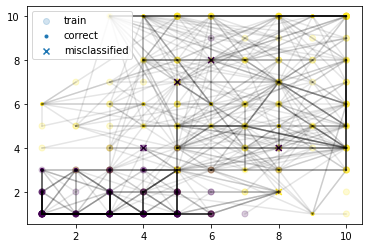

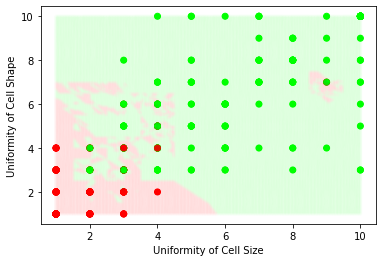

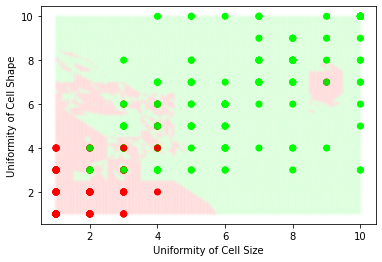

In [6]:
##Accuracy of Predicting Test Data

model=KNN(K=10)

y_prob, knns = model.fit(x_train,y_train).predict(x_test)
print('knns shape:',knns.shape) #number of elements in each dimension
print('y_prob shape:',y_prob.shape)

y_pred = np.argmax(y_prob,axis=-1) #last axis
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(model.evaluate_acc(y_pred,y_test))
#print(f'accuracy is {accuracy*100:.1f}.')

#boolean array 
correct = y_test == y_pred
incorrect = np.logical_not(correct)

plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#Connect each node to k-nearest neighbours in the training set
for i in range (x_test.shape[0]):
  for k in range(model.K):
    hor = x_test[i,0], x_train[knns[i,k],0]
    ver = x_test[i,1], x_train[knns[i,k],1]
    plt.plot(hor, ver, 'k-', alpha=.1)

plt.legend()
plt.show()

##Plotting decision boundaries

x0v = np.linspace(np.min(x_corr[:,0]), np.max(x_corr[:,0]), 200)
x1v = np.linspace(np.min(x_corr[:,1]), np.max(x_corr[:,1]), 200)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

for k in range(1,3):
  model = KNN(K=k)

  y_train_prob = np.zeros((y_train.shape[0], C))
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
  extra = np.zeros((305,1))
  y_train_color = np.append(y_train_prob, extra, axis=1)

  #to get class probability of all the points in the 2D grid
  y_prob_all, _ = model.fit(x_train_corr, y_train).predict(x_all)
  
  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1
  extra = np.zeros((40000,1))
  y_pred_color = np.append(y_pred_all, extra, axis=1)

  plt.scatter(x_train_corr[:,0], x_train_corr[:,1], c=y_train_color, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_color, marker='.', alpha=0.01)
  plt.ylabel('Uniformity of Cell Shape')
  plt.xlabel('Uniformity of Cell Size')
  plt.show()



**Implementation of KNN (Hepatitis Data)**

knns shape: (22, 10)
y_prob shape: (22, 2)
0.7727272727272727
accuracy is 77.3.


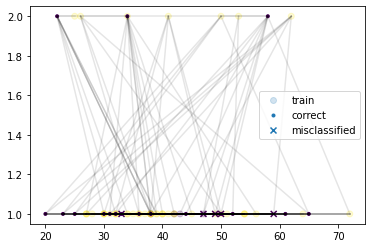

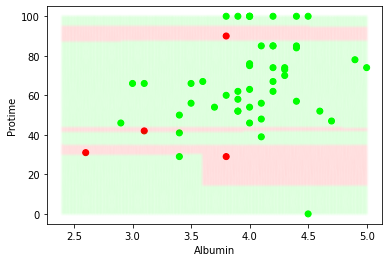

In [7]:
##Accuracy of Predicting Test Data
model=KNN(K=10)

y_prob, knns = model.fit(x_hep_train,y_hep_train).predict(x_hep_test)
print('knns shape:',knns.shape) #number of elements in each dimension
print('y_prob shape:',y_prob.shape)

y_pred = np.argmax(y_prob,axis=-1) #last axis
accuracy = np.sum(y_pred == y_hep_test)/y_hep_test.shape[0]
print(model.evaluate_acc(y_pred,y_hep_test))
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array 
correct = y_hep_test == y_pred
incorrect = np.logical_not(correct)

plt.scatter(x_hep_train[:,0], x_hep_train[:,1], c=y_hep_train, marker='o', alpha=.2, label='train')
plt.scatter(x_hep_test[correct,0], x_hep_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_hep_test[incorrect,0], x_hep_test[incorrect,1], marker='x', c=y_hep_test[incorrect], label='misclassified')

#Connect each node to k-nearest neighbours in the training set
for i in range (x_hep_test.shape[0]):
  for k in range(model.K):
    hor = x_hep_test[i,0], x_hep_train[knns[i,k],0]
    ver = x_hep_test[i,1], x_hep_train[knns[i,k],1]
    plt.plot(hor, ver, 'k-', alpha=.1)

plt.legend()
plt.show()

##Plotting decision boundaries
x0v = np.linspace(np.min(hep_x_corr[:,0]), np.max(hep_x_corr[:,0]), 200)
x1v = np.linspace(np.min(hep_x_corr[:,1]), np.max(hep_x_corr[:,1]), 200)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

for k in range(1,2):
  model = KNN(K=k)

  y_train_prob = np.zeros((y_hep_train.shape[0], C))
  y_train_prob[np.arange(y_hep_train.shape[0]), y_hep_train] = 1
  extra = np.zeros((52,1))
  y_train_color = np.append(y_train_prob, extra, axis=1)

  #to get class probability of all the points in the 2D grid
  y_prob_all, _ = model.fit(x_hep_train_corr, y_hep_train).predict(x_all)
  
  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1
  extra = np.zeros((40000,1))
  y_pred_color = np.append(y_pred_all, extra, axis=1)

  plt.scatter(x_hep_train_corr [:,0], x_hep_train_corr [:,1], c=y_train_color, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_color, marker='.', alpha=0.01)
  
  plt.ylabel('Protime')
  plt.xlabel('Albumin')
  plt.show()
  

**Decision Tree Implementation (Breast Cancer Data)**

for depth 5 accuracy is 92.3.


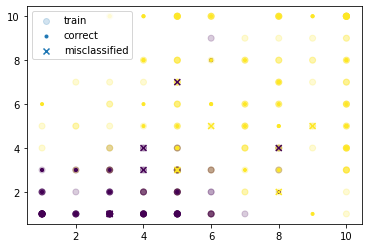

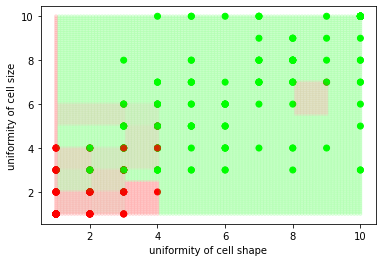

In [8]:
##Accuracy of Predicting Test Data
#fit tree to training data breast cancer

i=5

tree = DecisionTree(max_depth=i)
probs_test = tree.fit(x_train, y_train).predict(x_test)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'for depth {i} accuracy is {accuracy*100:.1f}.')


#visualization
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.show()

##Plotting decision boundaries
x0v = np.linspace(np.min(x_corr[:,0]), np.max(x_corr[:,0]), 100)
x1v = np.linspace(np.min(x_corr[:,1]), np.max(x_corr[:,1]), 100)

x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=10)

y_train_prob = np.zeros((y_train.shape[0], C))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
extra = np.zeros((305,1))
y_train_color = np.append(y_train_prob, extra, axis=1)


y_prob_all = model.fit(x_train_corr, y_train).predict(x_all)
extra = np.zeros((10000,1))
y_prob_color = np.append(y_prob_all, extra, axis=1)

plt.scatter(x_train_corr[:,0], x_train_corr[:,1], c=y_train_color, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_color, marker='.', alpha=.1)
plt.ylabel('uniformity of cell size')
plt.xlabel('uniformity of cell shape')
plt.show()



**Decision Tree Implementation (Hepatitis Data)**

for depth 5 accuracy is 77.3.


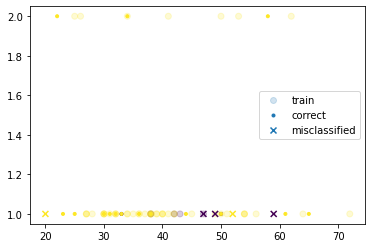

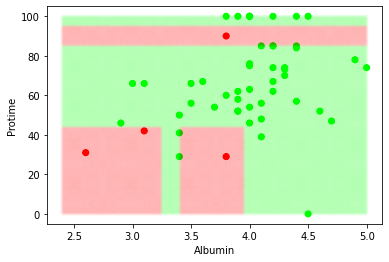

In [9]:
##Accuracy of Predicting Test Data

i=5

tree = DecisionTree(max_depth=i)
probs_test = tree.fit(x_hep_train, y_hep_train).predict(x_hep_test)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_hep_test)/y_hep_test.shape[0]
print(f'for depth {i} accuracy is {accuracy*100:.1f}.')


#visualization
correct = y_hep_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_hep_train[:,0], x_hep_train[:,1], c=y_hep_train, marker='o', alpha=.2, label='train')
plt.scatter(x_hep_test[correct,0], x_hep_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_hep_test[incorrect,0], x_hep_test[incorrect,1], marker='x', c=y_hep_test[incorrect], label='misclassified')
plt.legend()
plt.show()


##Plotting decision boundaries
x0v = np.linspace(np.min(hep_x_corr[:,0]), np.max(hep_x_corr[:,0]), 300)
x1v = np.linspace(np.min(hep_x_corr[:,1]), np.max(hep_x_corr[:,1]), 300)

x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=10)

y_train_prob = np.zeros((y_hep_train.shape[0], C))
y_train_prob[np.arange(y_hep_train.shape[0]), y_hep_train] = 1
extra = np.zeros((52,1))
y_train_color = np.append(y_train_prob, extra, axis=1)


y_prob_all = model.fit(x_hep_train_corr, y_hep_train).predict(x_all)
extra = np.zeros((90000,1))
y_prob_color = np.append(y_prob_all, extra, axis=1)


plt.scatter(x_hep_train_corr[:,0], x_hep_train_corr[:,1], c=y_train_color, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_color, marker='.', alpha=.01)
plt.ylabel('Protime')
plt.xlabel('Albumin')
plt.show()